### Part A -  Feed Forward Neural Network with Back Propagation 

In this section we are creating a fully connected feed forward neural network. ( 2 successive layers represents a bipartite graph)

Neural Network operates back and forth based on the below mentioned mechanism -

#### Feed Forward

Input signals are multiplied based on the connection weights and carried forward to the corresponding hidden nodes. The proces repeats until all the hidden layers are surpassed and finally we arrive at an output value.
        
#### BackPropagation 

Here we compute the error between our actual and predicted value based on cost function and initiate gradient descent to optimise each weights. Here weight gradients are propagated backwards to update each weights according to their contribution towards error.

Apart from the above mechanism explained activation function that takes sum of weighted inputs and passes it through a range function that produce values within a range. Ex:  Sigmoid ( range  - (0 -1) ) & RELU (range (0 - max) ) functions.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

sns.set()


# Backpropagation explained

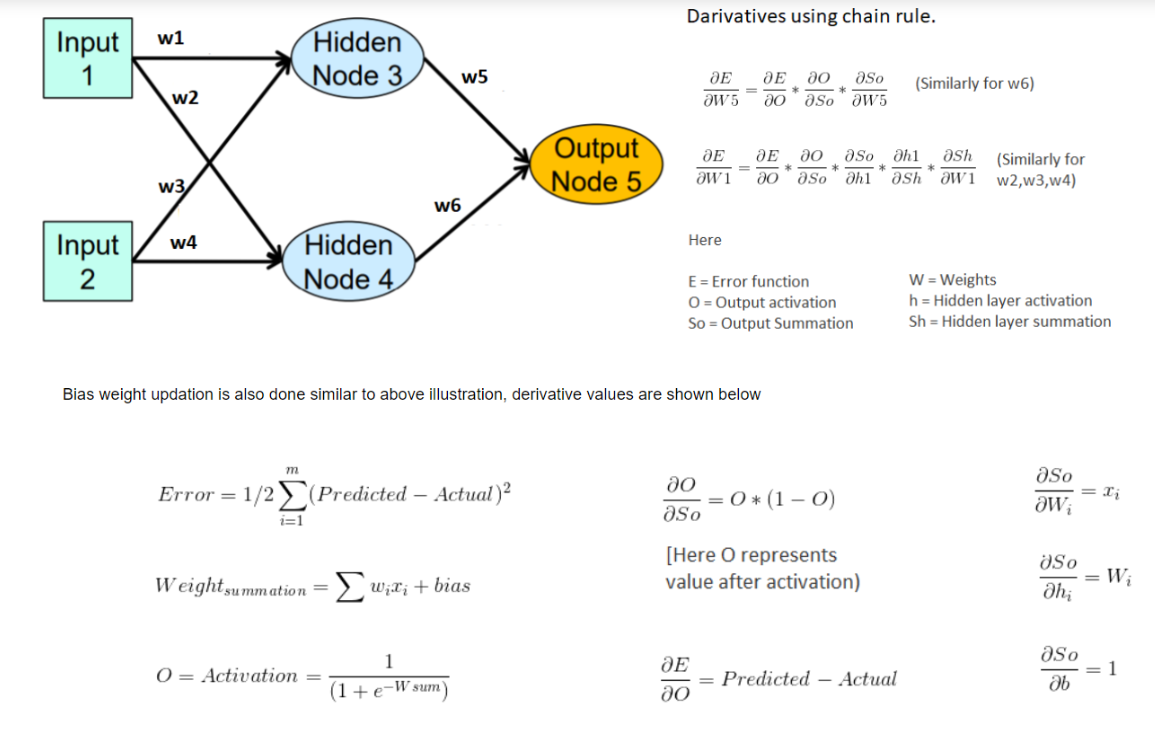

### Class  FF_Neural_Net

Method Adopted:

    - Stochastic Gradient Descent
    - Cost function - Sum of squared errors
    - 20 % of epoch data used for Cross Validation 
    - Input Nodes - Customisable
    - 1 hidden layer - Fixed
    - Hidden Layer Nodes Customisable
    - 1 Output layer - Fixed

Parmeters Available:

    -Epoch 
    -Learning rate
    -Input nodes
    -Hidden nodes


Methods Available:

    - Train() --> Starts training Neural Network as per the parameters passed while object creation
    - Test() --> Takes in test data and returns the ouput label
    - Get_cost_epoch() ---> Return dictionary with cost @ each epoch
    
##### NOTE : 

- Variable names assigned in backpropagation are as per the naming convention followed in the above image
- On each epoch holding out 20% data drawn at random from train set for cross validation, to inspect overfitting.            

In [2]:
class FF_Neural_Net():
    
   
    
    def __init__ (self,train_data,hidden_nodes,epoch,learning_rate):
        
             
        np.random.seed(10)
        
        # Storing values between 0.25 and 0.75
        weight_values = [val/100 for val in range(25,75)]
        
        self.train_data = train_data
        self.input_nodes = train_data.shape[1] - 1
        self.hidden_nodes = hidden_nodes
        self.epoch = epoch
        self.alpha  = learning_rate
        self.error_epoch = {}
         
        #held out 
        self.held_out = (int((len(self.train_data) * 80 ) / 100),len(self.train_data))
        
        # Input layer =  2 nodes & Hidden layer = 4 nodes
        self.input_layer = range(0,self.input_nodes)
        self.hidden_layer_1 = range(0,self.hidden_nodes)

        # Bias have constant value +1 and weights are initialised with 0.5
        self.b0 = np.random.choice(weight_values,size=len(self.hidden_layer_1),replace=True)
        self.b1 = 0.5

        # Generating random weights for where row = No of hidden layer & column = No of inputs
        self.hidden_layer1_weights = np.random.choice(weight_values,size=[len(self.hidden_layer_1),len(self.input_layer)],replace=True)
        
        
        # Updating Output layer weights randomly
        self.output_layer_weights = np.round(np.random.rand(len(self.hidden_layer_1)),2)

    
    
    def get_sigmoid_derivative(self,x):
        return x*(1-x)

    def get_sigmoid (self,x):
        return 1 / (1+np.exp(-x))        
    
    def get_cost_epoch(self):
        return self.error_epoch
    
    
    
    
    def train(self):
        
        
        #Function to train the NN -  Initiates Feed forward and Back propagation iteratively
        
        for epoch in range(1,self.epoch+1):
            errors = []
            train = self.train_data.values
            np.random.shuffle(train)
            training_set = train[0:self.held_out[0]]
            cv_data = train[self.held_out[0]:self.held_out[1]]
            
            for row in training_set:
                
                ip_array = row[:len(self.input_layer)]

                #Feed forward --- Performing summation using matrix multiplication and adding bias to the result
                

                # 1) Summation of Wi*xi  + c
                hl1_weights = self.hidden_layer1_weights.transpose()
                hl1_summation = ip_array.dot(hl1_weights) + np.array(self.b0)
                hl1_activation = self.get_sigmoid(hl1_summation)

                
                # 2) Summation and activation operations from hidden to output layer

                o_weights = self.output_layer_weights.transpose()
                o_summation = hl1_activation.dot(o_weights) + self.b1
                o_activation = self.get_sigmoid(o_summation) 
                

                # Calculating Cost/error function
                error = 0.5 * ((o_activation - row[-1])**2)
                errors.append(error.item())


                
                #Backpropagation - Variable names assigned as per the notation expained in the derivation above
                
                
                # Derivative of E/O
                dE_dO = o_activation - row[-1]

                # Derivative of Output activation fn 
                dO_dSo = self.get_sigmoid_derivative(o_activation)
                
                #Output layer weights
                dSo_dWo = hl1_activation

                dE_dSo = dE_dO * dO_dSo
                
                dE_dWo = dE_dSo * dSo_dWo
                
                dE_dBo = dE_dSo # as bias value is 1
                
                #Hidden layer weights
                
                dSo_dH = self.output_layer_weights
                
                dH_dSh = self.get_sigmoid_derivative(hl1_activation)

                dSo_dSh = np.multiply(dSo_dH,dH_dSh)
                
                dE_dSh = np.reshape( dE_dO * dO_dSo * dSo_dSh ,newshape = (len(self.hidden_layer_1),1))
                dSh_dWh = ip_array.reshape(1,len(self.input_layer))
                
                
                dE_dWh = dE_dSh.dot(dSh_dWh)
                
                # dE_dBh = dE_dSh    as bias value is 1

                #Updating output layer weights
                self.output_layer_weights =  self.output_layer_weights- (self.alpha * dE_dWo)
                
                self.b1 = self.b1 - (self.alpha* dE_dBo)
                
                
                #Updating hidden layer weights
                self.hidden_layer1_weights =  self.hidden_layer1_weights - (self.alpha*dE_dWh)
                
                self.b0 = self.b0 - (self.alpha * dE_dSh.reshape(1,len(self.hidden_layer_1))[0])

                
            self.error_epoch[epoch] = np.mean(errors)
            if (epoch % 10 == 0) or (epoch == 1) : 
                op = self.test(cv_data)
                acc= accuracy_score(cv_data[:,-1], op)
                print('Epoch {} - Error = {} - CV accuracy - {}'.format(epoch,np.mean(errors),acc))


    
    
    def test(self,test):
       
        op = []

        for i in test:
            
            ip_array = i[:len(self.input_layer)]
            
            'Feed forward --- Performing summation using matrix multiplication and adding bias to the result'
            
            # 1) Summation of Wi*xi  + c
            hl1_weights = self.hidden_layer1_weights.transpose()
            hl1_summation = ip_array.dot(hl1_weights) + np.array(self.b0)
            
            # 2) Sigmoid activation 
            hl1_activation = 1 / ( 1 + np.exp(-hl1_summation))
            
            # 3) Summation and activation operations from hidden to output layer
            
            o_weights = self.output_layer_weights.transpose()
            o_summation = hl1_activation.dot(o_weights) + self.b1
            o_activation = 1 / ( 1 + np.exp(-o_summation))
            
            if o_activation > 0.5:
                o = 1
            else:
                o = 0
            op.append(o)
            
        return op





### PART - B  - Testing the NN on circles datset

##### Train to Test ratio - 3 : 1

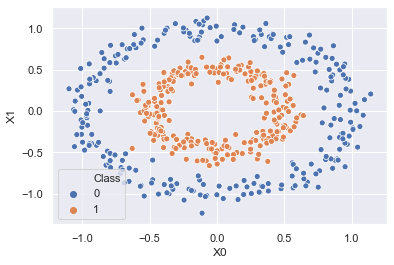

In [3]:

df = pd.read_csv('circles500.csv')


train = df.iloc[:375]
test = df.iloc [375:]
sns.scatterplot(x='X0',y='X1',data=df,hue='Class')

Model Parameters 

- Epoch = 100 ( Inspected with smaller epochs but model was underfit)
    
- Hidden Nodes = 3 ( Since we have only 2 inputs increasing the number of nodes might just extrapolate the combinations)
    
- Learning Rates = 0.5 ( Its chosen to be high as we are dealing with a small dataset and conversely if its decreased  number of epochs needed for convergence also increases and inturns becomes computationally intensive).

In [6]:


nn = FF_Neural_Net(train,hidden_nodes = 3 ,epoch=100,learning_rate = 0.5)  


nn.train()

er_epoch = nn.get_cost_epoch()

op = nn.test(test.values)

cm = confusion_matrix(test.iloc[:,2].values, op)
print('\nConfusion Matrix\n{}'.format(cm))


acc= accuracy_score(test.iloc[:,2], op)
print('\nAccuracy of the model - {}\n'.format(acc))


print('\nClassification Report\n\n{}\n'.format(classification_report(test.iloc[:,2], op, target_names=['pos', 'neg'])))

Epoch 1 - Error = 0.13197432475996246 - CV accuracy - 0.5333333333333333
Epoch 10 - Error = 0.13037305939899924 - CV accuracy - 0.5866666666666667
Epoch 20 - Error = 0.0966868819870413 - CV accuracy - 0.7466666666666667
Epoch 30 - Error = 0.018989329688035572 - CV accuracy - 0.9733333333333334
Epoch 40 - Error = 0.011277707019171182 - CV accuracy - 0.9866666666666667
Epoch 50 - Error = 0.010026882897554493 - CV accuracy - 1.0
Epoch 60 - Error = 0.00865304659072023 - CV accuracy - 1.0
Epoch 70 - Error = 0.006974883994799208 - CV accuracy - 0.9866666666666667
Epoch 80 - Error = 0.00704732384303246 - CV accuracy - 1.0
Epoch 90 - Error = 0.005007929119736312 - CV accuracy - 0.9866666666666667
Epoch 100 - Error = 0.005609652062655125 - CV accuracy - 1.0

Confusion Matrix
[[60  0]
 [ 1 64]]

Accuracy of the model - 0.992


Classification Report

              precision    recall  f1-score   support

         pos       0.98      1.00      0.99        60
         neg       1.00      0.98      

#### Error VS Epoch

We can see that after epoch 40 the model has converged and we have reached the minima and the corresponding graph is plotted below

Text(0, 0.5, 'Cost')

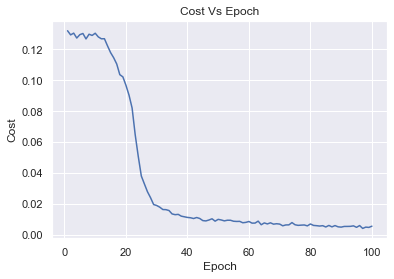

In [5]:

plt.plot(list(er_epoch.keys()),list(er_epoch.values()))
plt.title('Cost Vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cost')

### Model Performance

Performace of the model is good as Accuracy and F1 score are 98 % . Model was able to perform well on the validation set as epoch increases and converges quickly. There is no trace of overfitting as we can't see any significant difference between validation set accuracy and test accuracy.

#### Inference : 

Keeping in mind the dataset volume and set of variables involved, 1 layer Neural Network is performing better. As ANN are able to capture non-linearity the data on hand is perfectly non linear without much of noise. Hence we obtain  precise classification.

### Part 3 - CIFAR

##### Note - Code adopted to load CIFAR dataset into Jupyter notebook was taken from the Notebook shared as reference to this assignment.

In [7]:
# This function taken from the CIFAR website

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


### Chose Batch1 as the subset for CIFAR NN implementation throughout this report

In [8]:
# Below functions was taken from the CIFAR Notebook shared for reference - Author Michael Madden

def loadbatch(batchname):
    folder = 'cifar-10-batches-py'
    batch = unpickle(folder+"/"+batchname)
    return batch

def loadlabelnames():
    folder = 'cifar-10-batches-py'
    meta = unpickle(folder+"/"+'batches.meta')
    return meta[b'label_names']

def visualise(data, index):

    picture = data[index]
    picture.shape = (3,32,32) 
    picture = picture.transpose([1, 2, 0])
    plt.imshow(picture)
    plt.show()
    
    

batch1 = loadbatch('data_batch_1')
data = batch1[b'data']
labels = batch1[b'labels']
names = loadlabelnames()

### Classes given for classification -> Frog - 6 and Horse - 7

In [9]:


frog_horse_dict = {idx : 0 if lab == 6 else 1 for idx,lab in enumerate(labels) if lab in (6,7)}
data_fh = data[list(frog_horse_dict.keys())]

Actual Image


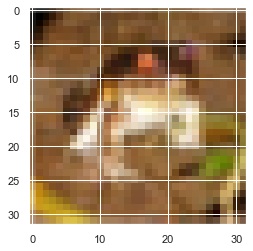

Actual image with only red channel


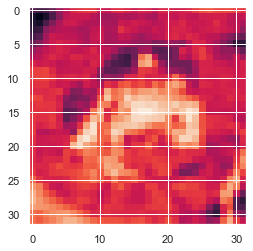

Actual Image


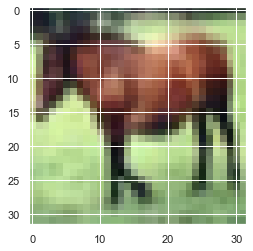

Actual image with only red channel


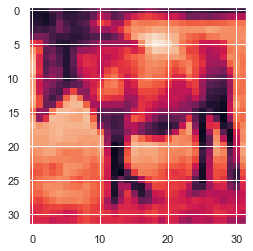

In [10]:

# Display  images from the batch
for i in range (0,2):
    print('Actual Image')
    visualise(data_fh, i)
    RGB =  data_fh[i].reshape(3,32,32)
    R,G,B = RGB[0],RGB[1],RGB[2]
    print('Actual image with only red channel')
    plt.imshow(R)
    plt.show()

### Filtering only Red channel values and normalised using max value

In [11]:


cifr_df = pd.DataFrame(data_fh)
cifr_df = cifr_df.iloc[:,:1024] # filtering only red channel values

# Max normalisation
cifr_df = cifr_df/255 
cifr_df['labels'] = list(frog_horse_dict.values())

#### CIFR dataset for classes frog and horse

In [12]:
cifr_df

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,labels
0,0.231373,0.168627,0.196078,0.266667,0.384314,0.466667,0.545098,0.568627,0.584314,0.584314,...,0.466667,0.509804,0.470588,0.360784,0.403922,0.666667,0.847059,0.592157,0.482353,0
1,0.109804,0.117647,0.129412,0.243137,0.247059,0.121569,0.113725,0.164706,0.215686,0.262745,...,0.384314,0.462745,0.474510,0.439216,0.509804,0.517647,0.415686,0.407843,0.396078,1
2,0.556863,0.674510,0.690196,0.725490,0.847059,0.882353,0.776471,0.509804,0.462745,0.513725,...,0.698039,0.592157,0.337255,0.298039,0.564706,0.647059,0.619608,0.619608,0.639216,1
3,0.643137,0.635294,0.635294,0.639216,0.635294,0.639216,0.643137,0.643137,0.647059,0.647059,...,0.521569,0.509804,0.509804,0.505882,0.501961,0.478431,0.486275,0.486275,0.470588,1
4,0.090196,0.184314,0.203922,0.352941,0.533333,0.745098,0.572549,0.200000,0.286275,0.415686,...,0.745098,0.737255,0.745098,0.760784,0.756863,0.749020,0.745098,0.737255,0.752941,0
5,0.337255,0.376471,0.450980,0.325490,0.356863,0.364706,0.337255,0.290196,0.329412,0.286275,...,0.301961,0.254902,0.313725,0.290196,0.250980,0.274510,0.172549,0.172549,0.176471,0
6,0.494118,0.400000,0.458824,0.494118,0.505882,0.541176,0.560784,0.572549,0.552941,0.521569,...,0.615686,0.717647,0.682353,0.556863,0.600000,0.517647,0.521569,0.705882,0.658824,0
7,0.635294,0.643137,0.662745,0.701961,0.725490,0.752941,0.784314,0.800000,0.819608,0.823529,...,0.376471,0.658824,0.756863,0.831373,0.862745,0.886275,0.905882,0.913725,0.921569,0
8,0.372549,0.345098,0.337255,0.349020,0.360784,0.360784,0.345098,0.368627,0.388235,0.384314,...,0.321569,0.345098,0.364706,0.368627,0.380392,0.384314,0.392157,0.411765,0.423529,1
9,0.388235,0.384314,0.392157,0.403922,0.411765,0.419608,0.423529,0.431373,0.447059,0.450980,...,0.803922,0.815686,0.815686,0.807843,0.811765,0.811765,0.815686,0.823529,0.819608,1


### CIFAR  Test - Train split is in the ratio 1: 3

In [13]:


train_cifr = cifr_df.iloc[:1550]
test_cifr = cifr_df.iloc [1550:]

Model Parameters 

- Hidden nodes = 50 ( 1/20 of the input)
- Epoch = 200 ( As the hidden nodes are limited using higher epoch)
- Learning rate = 0.1 

In [14]:


# best params 10 hiden nodes and 0.1 & 80 % held out
nn = FF_Neural_Net(train_cifr,hidden_nodes = 50 ,epoch=200,learning_rate = 0.1)  

nn.train()
 
op = nn.test(test_cifr.values)


cm = confusion_matrix(test_cifr.iloc[:,-1].values, op)
print('\nConfusion Matrix\n{}'.format(cm))

acc= accuracy_score(test_cifr.iloc[:,-1], op)
print('\nAccuracy of the model - {}\n'.format(acc))




Epoch 1 - Error = 0.2532258064242088 - CV accuracy - 0.4838709677419355
Epoch 10 - Error = 0.2568548386818804 - CV accuracy - 0.5129032258064516
Epoch 20 - Error = 0.2572580644882884 - CV accuracy - 0.5161290322580645
Epoch 30 - Error = 0.2572580644882883 - CV accuracy - 0.5161290322580645
Epoch 40 - Error = 0.25322580642420855 - CV accuracy - 0.4838709677419355
Epoch 50 - Error = 0.25040322577935276 - CV accuracy - 0.4612903225806452
Epoch 60 - Error = 0.25282258061780055 - CV accuracy - 0.4806451612903226
Epoch 70 - Error = 0.2560483870690643 - CV accuracy - 0.5064516129032258
Epoch 80 - Error = 0.25604838706906413 - CV accuracy - 0.5064516129032258
Epoch 90 - Error = 0.25806451610110404 - CV accuracy - 0.5225806451612903
Epoch 100 - Error = 0.2508064515857604 - CV accuracy - 0.4645161290322581
Epoch 110 - Error = 0.25040322577935237 - CV accuracy - 0.4612903225806452
Epoch 120 - Error = 0.2540322580370242 - CV accuracy - 0.49032258064516127
Epoch 130 - Error = 0.24758064513449643 - 

#### Model Performance

The 1 layer NN constructed in this part is doing badly for the CIFAR data . We can witness 'Accuracy Paradox' where the model just lables all instances as 0 or 1. Overall performance is poor and model is clearly underfit. 

Reasons for the above mentioned behaviour - 

- Since NN is fully connected, hidden layer nodes can extract specific features and gets confused by all signals from all input nodes.

- Image classification needs to be dealt as  Convolutional neural network problem, where image data is processed using convolution & pooling layers to extract the spatial feature along with dimensionality reduction and later passed into a Fully connected network. But here image preprocessing part is not done and actual data is directly fed to network


### Part 4 Enhancement

1 Two layer Fully Connected Neural Network

2 Effect of RELU activation

### 1)  Two layered Network 


### Class  FF_Neural_Net

Method Adopted:

    - Stochastic Gradient Descent
    - Cost function - Sum of squared errors
    - 20 % of epoch data used for Cross Validation 
    - Input Nodes - Customisable
    - 2 hidden layer - Fixed
    - Hidden Layer Nodes Customisable
    - 1 Output layer - Fixed

Parmeters Available:

    -Epoch 
    -Learning rate
    -Input nodes
    -Hidden layer nodes


Methods Available:

    - Train() --> Starts training Neural Network as per the parameters passed while object creation
    - Test() --> Takes in test data and returns the ouput label
    - Get_cost_epoch() ---> Return dictionary with cost @ each epoch
    
##### NOTE : 

- Reusing the class defined earlier for 1 layer NN with some modifications.
- Variable names assigned in backpropagation are as per the naming convention followed in the above image
- On each epoch holding out 20% data drawn at random from train set for cross validation, to inspect overfitting.

In [21]:
class FF_Neural_Net2():
    
   
    def __init__ (self,train_data,hidden_layer_1_nodes,epoch,learning_rate,hidden_layer_2_nodes):

        np.random.seed(10)
        
        # Storing values between 0.25 and 0.75
        weight_values = [val/100 for val in range(-75,75)]
        
        self.train_data = train_data
        self.input_nodes = train_data.shape[1] -1
        self.hidden_nodes = hidden_layer_1_nodes
        self.epoch = epoch
        self.alpha  = learning_rate
        self.error_epoch = {}
        self.hidden_layer_2_nodes = hidden_layer_2_nodes
         
        #held out 
        self.held_out = (int((len(self.train_data) * 80 ) / 100),len(self.train_data))
        
        # Input layer =  2 nodes & Hidden layer = 4 nodes
        self.input_layer = range(0,self.input_nodes)
        self.hidden_layer_1 = range(0,self.hidden_nodes)
        self.hidden_layer_2 = range(0,self.hidden_layer_2_nodes)
        
        # Bias have constant value +1 and weights are initialised with 0.5
        self.b0 = np.random.choice(weight_values,size=len(self.hidden_layer_1),replace=True)
        self.b1 = np.random.choice(weight_values,size=len(self.hidden_layer_2),replace=True)
        self.b2 = 0.5

        # Generating random weights for where row = No of hidden layer & column = No of inputs
        self.hidden_layer1_weights = np.random.choice(weight_values,size=[len(self.hidden_layer_1),len(self.input_layer)],replace=True)
        self.hidden_layer2_weights = np.random.choice(weight_values,size=[len(self.hidden_layer_2),len(self.hidden_layer_1)],replace=True)
        
        # Updating Output layer weights randomly
        self.output_layer_weights = np.round(np.random.rand(len(self.hidden_layer_2)),2)


    def get_sigmoid_derivative(self,x):
        return x*(1-x)

    def get_sigmoid (self,x):
        return 1 / (1+np.exp(-x))        
    

    def train(self):
        
        for epoch in range(1,self.epoch+1):
            errors = []
            train = self.train_data.values
            np.random.shuffle(train)
            training_set = train[0:self.held_out[0]]
            cv_data = train[self.held_out[0]:self.held_out[1]]
            
            for row in training_set:
                
 
                

                ip_array = row[:len(self.input_layer)]

                'Feed forward --- Performing summation using matrix multiplication and adding bias to the result'

                # 1) Summation of Wi*xi  + c
                hl1_weights = self.hidden_layer1_weights.transpose()
                hl1_summation = ip_array.dot(hl1_weights) + np.array(self.b0)
                hl1_activation = self.get_sigmoid(hl1_summation)

                
                hl2_weights = self.hidden_layer2_weights.transpose()
                hl2_summation = hl1_activation.dot(hl2_weights) + np.array(self.b1)
                hl2_activation = self.get_sigmoid(hl2_summation)
                
                # 2) Summation and activation operations from hidden to output layer

                o_weights = self.output_layer_weights.transpose()
                o_summation = hl2_activation.dot(o_weights) + self.b2
                o_activation = self.get_sigmoid(o_summation) 


                # Calculating Cost/error function
                error = 0.5 * ((o_activation - row[-1])**2)
                errors.append(error.item())
                


                'Backpropagation - Variable names assigned as per the notation followed in the derivatives explained in the above picture'
                
                # Derivative of E/O
                dE_dO = o_activation - row[-1]

                # Derivative of Output activation fn 
                dO_dSo = self.get_sigmoid_derivative(o_activation)
                
                #Output layer weights
                dSo_dWo = hl2_activation

                dE_dSo = dE_dO * dO_dSo
                
                dE_dWo = dE_dSo * dSo_dWo
                
                dE_dBo = dE_dSo # as bias value is 1
                
                
                #Hidden layer 2 weights
                
                dSo_dH = self.output_layer_weights
                
                dH_dSh = self.get_sigmoid_derivative(hl2_activation)

                dSo_dSh = np.multiply(dSo_dH,dH_dSh)
                
                dE_dSh = np.reshape( dE_dSo * dSo_dSh ,newshape = (len(self.hidden_layer_2),1))
                
                dSh_dWh = hl1_activation.reshape(1,len(self.hidden_layer_1))
                
                dE_dWh = dE_dSh.dot(dSh_dWh)
                
                
                
                
                # dE_dBh = dE_dSh    as bias value is 1
                
                #Hidden layer 1 weights
                
                prev_derv = dE_dSh 
                
                dSh_dH1 = self.hidden_layer2_weights
                
                dE_dH1 = np.sum(prev_derv * dSh_dH1,axis =0).T.reshape(len(self.hidden_layer_1),1)
                
                dH1_dSh1 = np.reshape( self.get_sigmoid_derivative(hl1_activation) ,newshape = (len(self.hidden_layer_1),1))
                
                dSh1_dWh1 = ip_array.reshape(1,len(self.input_layer))
                
                dH1_dWh1 = dH1_dSh1.dot(dSh1_dWh1)
                
                dE_dWh1 = dH1_dWh1 * dE_dH1
                

                dE_db0 =   (dH1_dSh1 * self.b0.reshape(1,len(self.hidden_layer_1)).transpose()) * dE_dH1

                #Updating output layer weights
                self.output_layer_weights =  self.output_layer_weights- (self.alpha * dE_dWo)
                
                self.b2= self.b2 - (self.alpha* dE_dBo)
                
                
                #Updating hidden layer 2 weights
                self.hidden_layer2_weights =  self.hidden_layer2_weights - (self.alpha*dE_dWh)
                
                self.b1 = self.b1 - (self.alpha * dE_dSh.reshape(1,len(self.hidden_layer_2))[0])
                
                 #Updating hidden layer 1 weights
                self.hidden_layer1_weights =  self.hidden_layer1_weights - (self.alpha*dE_dWh1)
                
                self.b0 = self.b0  - (self.alpha * dE_db0.reshape(1,len(self.hidden_layer_1))[0])


            
            if (epoch % 10 == 0) or (epoch == 1) :
                op = self.test(cv_data)
                self.error_epoch[epoch] = np.mean(errors)
                acc= accuracy_score(cv_data[:,-1], op)
                print('Epoch {} - Error = {} - CV accuracy - {}'.format(epoch,np.mean(errors),acc))


    def test(self,test):

        op = []

        for i in test:
            
            ip_array = i[:len(self.input_layer)]
            
            'Feed forward --- Performing summation using matrix multiplication and adding bias to the result'
            hl1_weights = self.hidden_layer1_weights.transpose()
            hl1_summation = ip_array.dot(hl1_weights) + np.array(self.b0)
            hl1_activation = self.get_sigmoid(hl1_summation)
            
            hl2_weights = self.hidden_layer2_weights.transpose()
            hl2_summation = hl1_activation.dot(hl2_weights) + np.array(self.b1)
            hl2_activation = self.get_sigmoid(hl2_summation)

            # 2) Summation and activation operations from hidden to output layer

            o_weights = self.output_layer_weights.transpose()
            o_summation = hl2_activation.dot(o_weights) + self.b2
            o_activation = self.get_sigmoid(o_summation) 
            
            if o_activation > 0.5:
                o = 1
            else:
                o = 0
            op.append(o)
            
        return op


    def get_cost_epoch(self):
        return self.error_epoch



Model Parameters 

    -Epoch = 100 ( Inspected with smaller epochs but model performed poorly, chosen based on CV accuracy and error rate)
    
    -Hidden layer 1 Nodes = 50 ( Chose 1/20 of the input nodes as hidden nodes)
    
    -Hodden layer 2 nodes = 30 ( Precious layer has 50 nodes so tried to reduce the dimensionality)
    
    -Learning Rates = 0.1 ( Its chosen high because after inspecting smaller learning rate where convergence was too slow and needed to increase the epoch, which again was computationally intensive).

In [22]:


nn = FF_Neural_Net2(train_cifr,hidden_layer_1_nodes = 50 ,epoch=100,learning_rate = 0.1,hidden_layer_2_nodes = 30)  

nn.train()
 
op = nn.test(test_cifr.values)


cm = confusion_matrix(test_cifr.iloc[:,-1].values, op)
print('\nConfusion Matrix\n{}'.format(cm))


acc= accuracy_score(test_cifr.iloc[:,-1].values, op)
print('\nAccuracy of the model - {}\n'.format(acc))


print('\nClassification Report\n\n{}\n'.format(classification_report(test_cifr.iloc[:,-1].values, op, target_names=['frog', 'horse'])))


Epoch 1 - Error = 0.25601653157094223 - CV accuracy - 0.5064516129032258
Epoch 10 - Error = 0.2595922177679693 - CV accuracy - 0.535483870967742
Epoch 20 - Error = 0.1009789679275237 - CV accuracy - 0.7193548387096774
Epoch 30 - Error = 0.0782675886531301 - CV accuracy - 0.7774193548387097
Epoch 40 - Error = 0.0671127654106343 - CV accuracy - 0.8161290322580645
Epoch 50 - Error = 0.05152094606547574 - CV accuracy - 0.8483870967741935
Epoch 60 - Error = 0.046476510609585596 - CV accuracy - 0.864516129032258
Epoch 70 - Error = 0.04050839183048056 - CV accuracy - 0.9032258064516129
Epoch 80 - Error = 0.02380769857813752 - CV accuracy - 0.9580645161290322
Epoch 90 - Error = 0.019599760558195123 - CV accuracy - 0.964516129032258
Epoch 100 - Error = 0.018885782884254822 - CV accuracy - 0.9580645161290322

Confusion Matrix
[[174  68]
 [ 55 184]]

Accuracy of the model - 0.7442827442827443


Classification Report

              precision    recall  f1-score   support

        frog       0.76  

### Error VS Epoch

We can see that after epoch 80 the model starts to converge and corrsponding  graph is plotted below

Text(0, 0.5, 'Cost')

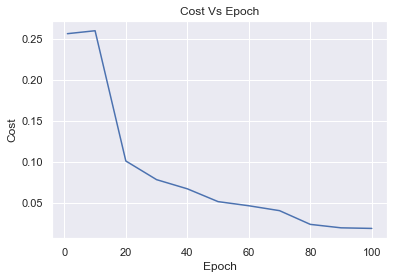

In [16]:
er_epoch = nn.get_cost_epoch()
plt.plot(list(er_epoch.keys()),list(er_epoch.values()))
plt.title('Cost Vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cost')

### Model Performance

Two layer Neural Network performs better than the single layer NN implemented for the same CIFAR dataset. The presence of additional layer is able to capture some spatial features of the image. Also eliminated Accuracy Paradox and Performace of the model is good comparitively as Accuracy and F1 score are 75 % . Model was able to perform well on the validation set as epoch increases and converges slowly. There is a trace of overfitting as we can see difference between final validation set accuracy and test accuracy is 20%. 

###### Further Extensions to this enhancement: 

- Hidden nodes can be increased and RELU activation function can be used to aid quick convergence.
        
- Here some configurations of the network are limited due to the computational resource available on the local machine, so various parameter settings can be experimented.
          
- Sparse Network can be incorporated as model tends to focus on certain spacial characteristics of the image.
        
###### Conclusion 

- Conventinal ANN implementation with 2 hidden layers is performing better than 1 layer network for low pixel binary image classification without incoroprating any of the CNN image processing techniques.


   

### Enhancement 2 -  Effect of ReLU activation 



### Class  FF_Neural_Net_Relu

Method Adopted:

    - Stochastic Gradient Descent
    - ReLu Activation function
    - Cost function - Sum of squared errors
    - 20 % of epoch data used for Cross Validation 
    - Input Nodes - Customisable
    - 1 hidden layer - Fixed
    - Hidden Layer Nodes Customisable
    - 1 Output layer - Fixed

Parmeters Available:

    -Epoch 
    -Learning rate
    -Input nodes
    -Hidden layer nodes


Methods Available:

    - Train() --> Starts training Neural Network as per the parameters passed while object creation
    - Test() --> Takes in test data and returns the ouput label
    - Get_cost_epoch() ---> Return dictionary with cost @ each epoch
    
##### NOTE : 

- Reusing the class defined earlier for 1 layer NN with some modifications in the activation function.
- Variable names assigned in backpropagation are as per the naming convention followed in the above image
- On each epoch holding out 20% data drawn at random from train set for cross validation, to inspect overfitting.

In [29]:
class FF_Neural_Net_Relu():
    
   
    
    def __init__ (self,train_data,hidden_nodes,epoch,learning_rate):
        
        
        np.random.seed(10)
        
        # Storing values between 0.25 and 0.75
        weight_values = [val/100 for val in range(25,75)]
        
        self.train_data = train_data
        self.input_nodes = train_data.shape[1] - 1
        self.hidden_nodes = hidden_nodes
        self.epoch = epoch
        self.alpha  = learning_rate
        self.error_epoch = {}
         
        #held out 
        self.held_out = (int((len(self.train_data) * 80 ) / 100),len(self.train_data))
        
        # Input layer =  2 nodes & Hidden layer = 4 nodes
        self.input_layer = range(0,self.input_nodes)
        self.hidden_layer_1 = range(0,self.hidden_nodes)

        # Bias have constant value +1 and weights are initialised with 0.5
        self.b0 = np.random.choice(weight_values,size=len(self.hidden_layer_1),replace=True)
        self.b1 = 0.5

        # Generating random weights for where row = No of hidden layer & column = No of inputs
        self.hidden_layer1_weights = np.random.choice(weight_values,size=[len(self.hidden_layer_1),len(self.input_layer)],replace=True)
        
        
        # Updating Output layer weights randomly
        self.output_layer_weights = np.round(np.random.rand(len(self.hidden_layer_1)),2)

    def get_relu_derivative(self,x):
        return 1.0*(x>0)

    def get_relu (self,x):
        return x*(x>0)
   
    def get_sigmoid_derivative(self,x):
        return x*(1-x)

    def get_sigmoid (self,x):
        return 1 / (1+np.exp(-x))        
    
    def get_cost_epoch(self):
        return self.error_epoch
    
    
    
    
    def train(self):
        
               
        #Function to train the NN -  Initiates Feed forward and Back propagation iteratively
        
        for epoch in range(1,self.epoch+1):
            errors = []
            train = self.train_data.values
            np.random.shuffle(train)
            training_set = train[0:self.held_out[0]]
            cv_data = train[self.held_out[0]:self.held_out[1]]
            
            for row in training_set:
                
                ip_array = row[:len(self.input_layer)]

                #Feed forward --- Performing summation using matrix multiplication and adding bias to the result
                
                # 1) Summation of Wi*xi  + c
                hl1_weights = self.hidden_layer1_weights.transpose()
                hl1_summation = ip_array.dot(hl1_weights) + np.array(self.b0)
                hl1_activation = self.get_relu(hl1_summation)

                
                # 2) Summation and activation operations from hidden to output layer

                o_weights = self.output_layer_weights.transpose()
                o_summation = hl1_activation.dot(o_weights) + self.b1
                o_activation = self.get_relu(o_summation) 
                

                # Calculating Cost/error function
                error = 0.5 * ((o_activation - row[-1])**2)
                errors.append(error.item())


                
                #Backpropagation - Variable names assigned as per the notation expained in the derivation above
                                
                # Derivative of E/O
                dE_dO = o_activation - row[-1]

                # Derivative of Output activation fn 
                dO_dSo = self.get_relu_derivative(o_activation)
                
                #Output layer weights
                dSo_dWo = hl1_activation

                dE_dSo = dE_dO * dO_dSo
                
                dE_dWo = dE_dSo * dSo_dWo
                
                dE_dBo = dE_dSo # as bias value is 1
                
                #Hidden layer weights
                
                dSo_dH = self.output_layer_weights
                
                dH_dSh = self.get_relu_derivative(hl1_activation)

                dSo_dSh = np.multiply(dSo_dH,dH_dSh)
                
                dE_dSh = np.reshape( dE_dO * dO_dSo * dSo_dSh ,newshape = (len(self.hidden_layer_1),1))
                dSh_dWh = ip_array.reshape(1,len(self.input_layer))
                
                
                dE_dWh = dE_dSh.dot(dSh_dWh)
                
                # dE_dBh = dE_dSh    as bias value is 1

                #Updating output layer weights
                self.output_layer_weights =  self.output_layer_weights- (self.alpha * dE_dWo)
                
                self.b1 = self.b1 - (self.alpha* dE_dBo)
                
                
                #Updating hidden layer weights
                self.hidden_layer1_weights =  self.hidden_layer1_weights - (self.alpha*dE_dWh)
                
                self.b0 = self.b0 - (self.alpha * dE_dSh.reshape(1,len(self.hidden_layer_1))[0])

                
            self.error_epoch[epoch] = np.mean(errors)
            if (epoch % 10 == 0) or (epoch == 1) : 
                op = self.test(cv_data)
                acc= accuracy_score(cv_data[:,-1], op)
                print('Epoch {} - Error = {} - CV accuracy - {}'.format(epoch,np.mean(errors),acc))


    
    
    def test(self,test):
        
        op = []

        for i in test:
            
            ip_array = i[:len(self.input_layer)]
            
            'Feed forward --- Performing summation using matrix multiplication and adding bias to the result'
            
            # 1) Summation of Wi*xi  + c
            hl1_weights = self.hidden_layer1_weights.transpose()
            hl1_summation = ip_array.dot(hl1_weights) + np.array(self.b0)
            
            # 2) Sigmoid activation 
            hl1_activation = 1 / ( 1 + np.exp(-hl1_summation))
            
            # 3) Summation and activation operations from hidden to output layer
            
            o_weights = self.output_layer_weights.transpose()
            o_summation = hl1_activation.dot(o_weights) + self.b1
            o_activation = 1 / ( 1 + np.exp(-o_summation))
            
            if o_activation > 0.5:
                o = 1
            else:
                o = 0
            op.append(o)
            
        return op




Model Parameters

-Epoch = 200 
-Hidden layer Nodes = 50 
-Learning Rates = 0.1 

The value of the parameters are taken same as it is in base neural network model on which the ennhancement has been done, so that the comparision of performance can be done more accurately.

In [33]:
nn = FF_Neural_Net_Relu(train_cifr,hidden_nodes = 50 ,epoch=200,learning_rate = 0.1)  

nn.train()
 
op = nn.test(test_cifr.values)


cm = confusion_matrix(test_cifr.iloc[:,-1].values, op)
print('\nConfusion Matrix\n{}'.format(cm))

acc= accuracy_score(test_cifr.iloc[:,-1], op)
print('\nAccuracy of the model - {}\n'.format(acc))

Epoch 1 - Error = 13065.616539232435 - CV accuracy - 0.5161290322580645
Epoch 10 - Error = 0.24314516129032257 - CV accuracy - 0.4870967741935484
Epoch 20 - Error = 0.24274193548387096 - CV accuracy - 0.4838709677419355
Epoch 30 - Error = 0.24274193548387096 - CV accuracy - 0.4838709677419355
Epoch 40 - Error = 0.2467741935483871 - CV accuracy - 0.5161290322580645
Epoch 50 - Error = 0.2495967741935484 - CV accuracy - 0.5387096774193548
Epoch 60 - Error = 0.24717741935483872 - CV accuracy - 0.5193548387096775
Epoch 70 - Error = 0.2439516129032258 - CV accuracy - 0.4935483870967742
Epoch 80 - Error = 0.2439516129032258 - CV accuracy - 0.4935483870967742
Epoch 90 - Error = 0.24193548387096775 - CV accuracy - 0.4774193548387097
Epoch 100 - Error = 0.24919354838709679 - CV accuracy - 0.535483870967742
Epoch 110 - Error = 0.2495967741935484 - CV accuracy - 0.5387096774193548
Epoch 120 - Error = 0.24596774193548387 - CV accuracy - 0.5096774193548387
Epoch 130 - Error = 0.2524193548387097 - CV

### Model Performance

ReLU activation function  performed slightly better than the sigmoid function in the single layer NN implemented for the same CIFAR dataset. The additional advantage of using ReLU function instead of sigmoid, it aid to quick convergence since gradient of ReLU is 0 or 1 and thus it also saves the computational cost.  

Further Extensions to this enhancement:
With additional hidden layer along with ReLU activation function , can increase the performance of the model significantly.

Conclusion :
Neural Network with ReLU activation function performs slightly better than the sigmoid function.

##### References

- http://cs229.stanford.edu/notes/cs229-notes-deep_learning.pdf
- https://www.cs.toronto.edu/~kriz/cifar.html
- https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
- https://www.anotsorandomwalk.com/backpropagation-example-with-numbers-step-by-step/ 